In [1]:
%matplotlib inline 
from plantcv import plantcv as pcv
import numpy as np
from matplotlib import pyplot as plt
from skimage.util import img_as_ubyte
from skimage.exposure import adjust_gamma
import pandas as pd

In [2]:
pcv.params.debug = None # turn off plotting while reading in the image cube 
pcv.params.dpi = 125

## Input data

In [3]:
infile = "imgs/PSII_HDR_032321_TEST_1.INF"

`ps` is an instance of the `PSII_data` class in PlantCV. The class stores each available dataset as attributes. The
class stores two dataset attributes (`datapath` and `filename`) and stores each of the datasets with the following
variable names: `darkadapted`, `lightadapted`, `chlorophyll`, `spectral`. The darkadapted, lightadapted, and 
chlorophyll datasets are stored as xarray DataArrays. The spectral dataset is stored as a PlantCV
`Spectral_data` class instance.

In [4]:
# Read fluorescence image data

# Inputs:
#   filename - Image file to be read in (should be an .INF file)
ps = pcv.photosynthesis.read_cropreporter(filename=infile)

Compiling: PSD
Compiling: PSL
Compiling: CHL
Compiling: CLR
Compiling: SPC


### Print what data were imported

In [5]:
print(ps)

PSII variables defined:
darkadapted
lightadapted
spectral
chlorophyll
datapath
filename


## Create a mask

In the code below, we select the chlorophyll "CHL" frame as our grayscale image from which the mask will be created. It is possible to use any frame for creating a mask, but it is easier to use an image with decent contrast between the object of interest (the plant) and the background. For example, "F0" is another frame that has been successfully used for segmentation. Below are examples of how to extract the frame of interest. 

In [6]:
#Pull out Chlorophyll frame for segmentation 
pcv.params.debug = "plot" # turn plotting back on to see debug images 
chl = ps.chlorophyll.sel(frame_label="Chl").data.squeeze()
fmin = ps.darkadapted.sel(frame_label="F0").data.squeeze() # pull out the F0 frame 

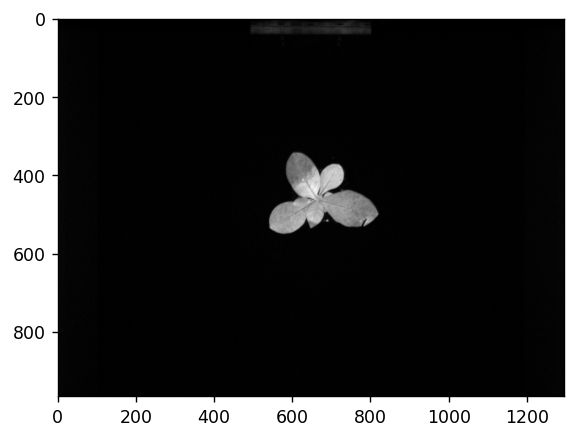

In [7]:
# Look at shape and plot of Chl frame 
np.shape(chl)
pcv.plot_image(chl)

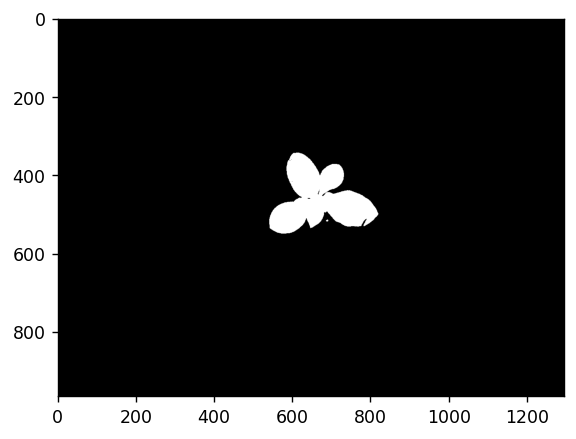

In [8]:
# Threshold the chlorophyll image

# Inputs:
#   gray_img        - Grayscale image data
#   max_value       - Value to apply above threshold (255 = white)
#   object_type     - 'light' (default) or 'dark'. If the object is lighter than the
#                       background then standard threshold is done. If the object is
#                       darker than the background then inverse thresholding is done.
plant_mask = pcv.threshold.otsu(gray_img=img_as_ubyte(chl), 
                          max_value=255, object_type="light")


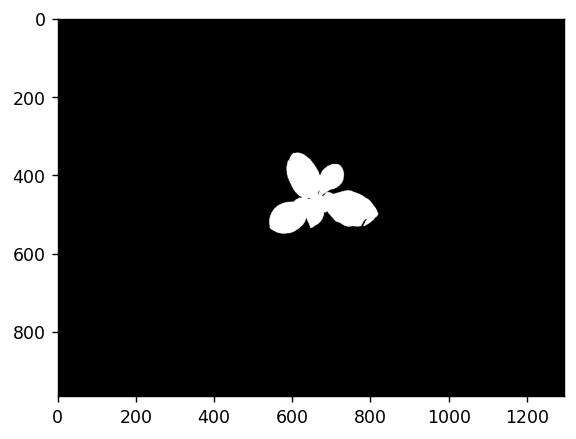

In [9]:
# Fill small objects (salt noise)

# Inputs:
#   bin_img         - Binary image data
#   size            - Minimum object area size in pixels (integer), smaller objects get filled in.
filled_mask = pcv.fill(bin_img=plant_mask, size=200)

Segmentation accuracy depends largely on the quality of the imaging data collection setup, but the importance of this accuracy also depends on the experimental questiton that a workflow aims to answer. In the case of photosynthesis/fluorescence datasets, it's recommended that segmentation of plants be more conservative. In other words, it's more detrimental for PSII results to have background signal captured within a plant mask than it is to exclude some true plant signal in analysis. Plant movement, reflections within imaging cabinets, and other factors can influence the signal around the edges of an object. To address this, we will preform a morphological erosion to remove the edges.  

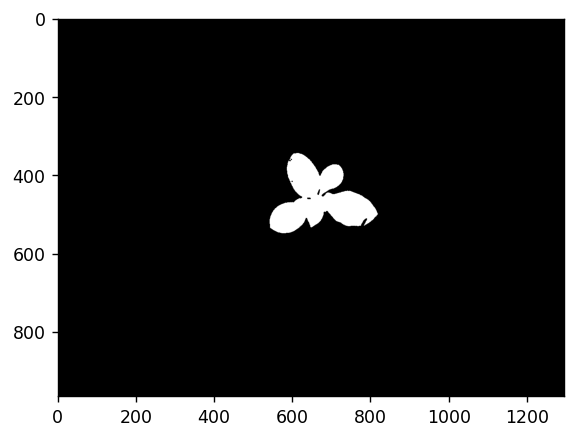

In [10]:
# Erode a small border of pixels from the mask 

# Inputs:
#   gray_img - Grayscale (usually binary) image data 
#   ksize - The size used to build a ksize x ksize 
#            matrix using np.ones. Must be greater than 1 to have an effect 
#   i - An integer for the number of iterations 
mask = pcv.erode(gray_img=filled_mask, ksize=3, i=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


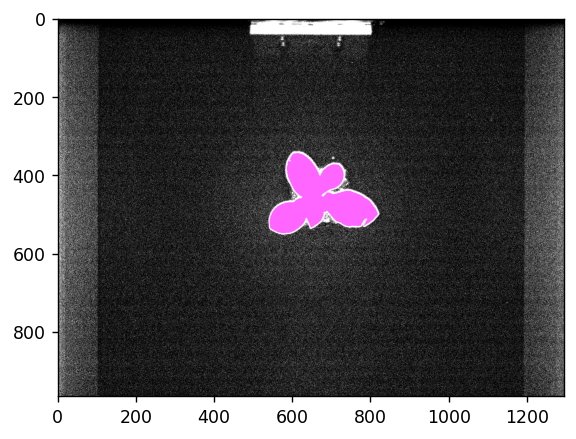

In [11]:
# Identify objects

# Inputs:
#   img             - RGB or grayscale image data for plotting
#   mask            - Binary mask used for detecting contours
plant_obj, plant_hier = pcv.find_objects(img=chl, mask=mask)

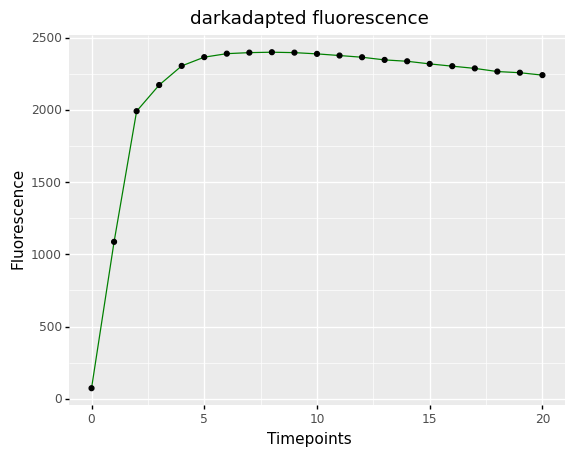

In [12]:
# Reassign frames 

# Inputs:
#    ps_da          = photosynthesis xarray DataArray
#    mask           = mask of plant (binary, single channel)

da, ind_fig, ind_df = pcv.photosynthesis.reassign_frame_labels(ps_da=ps.darkadapted, mask=mask)

Analyze individual frames by using the `analyze_nir_intensity` function. This function plots and stores pixel intensity values for any grayscale image. Utilizing the `label` parameter allows for using this function multiple times within a workflow. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


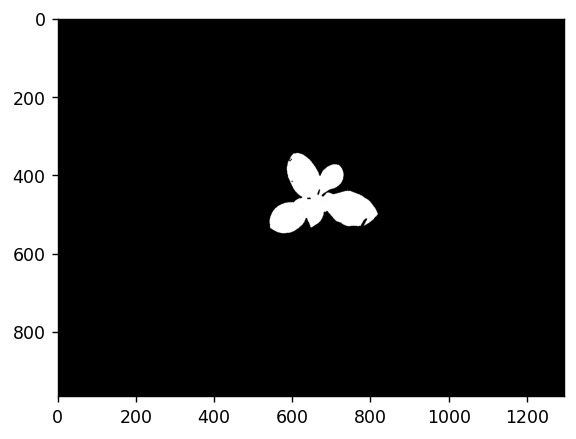

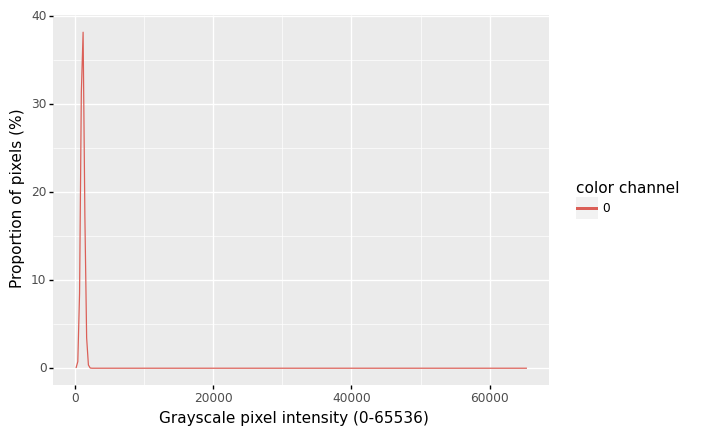

In [13]:
# Perform NIR signal analysis 

# Inputs: 
#   gray_img - 8 or 16-bit grayscale image data 
#   mask - Binary mask made from selected contours 
#   bins - Number of classes to divide the spectrum into 
#   histplot - If True, plots the histogram of intensity values 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

f0_hist = pcv.analyze_nir_intensity(gray_img=da.sel(frame_label="F0").data, mask=mask, label="F0")

Data is automatically stored into the outputs observations, but these are always accessible during a workflow by calling the dictionary. 

In [14]:

pcv.outputs.observations["F0"]["nir_median"]["value"]

1080.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


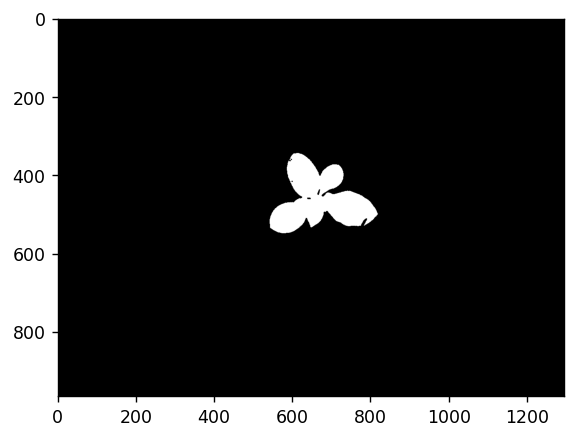

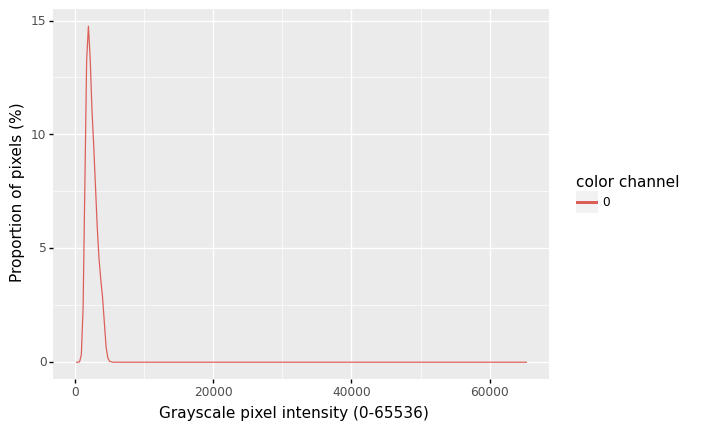

In [15]:
fm_hist = pcv.analyze_nir_intensity(gray_img=da.sel(frame_label="Fm").data, mask=mask, label="Fm")

In [16]:
pcv.outputs.observations["Fm"]["nir_median"]["value"]

2261.0

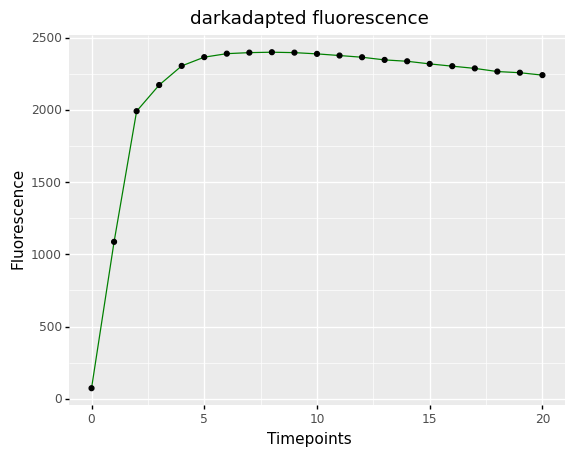

In [17]:
dark_da, dark_fig, dark_df = pcv.photosynthesis.reassign_frame_labels(ps_da=ps.darkadapted, mask=mask)

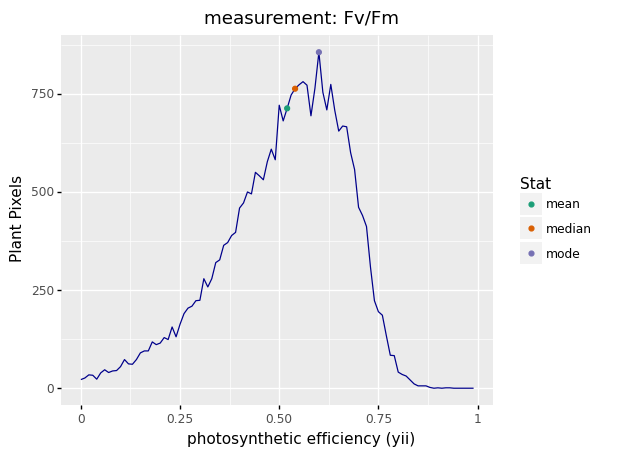

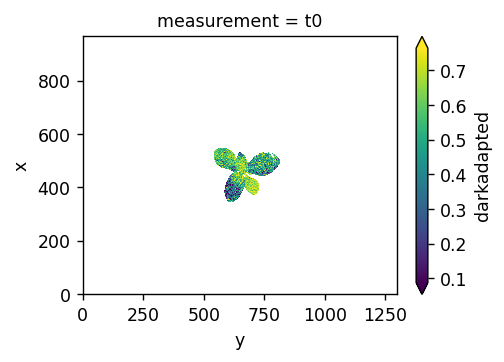

In [18]:
fvfm, fvfm_hist = pcv.photosynthesis.analyze_yii(ps_da=dark_da, mask=mask, measurement_labels=["Fv/Fm"])


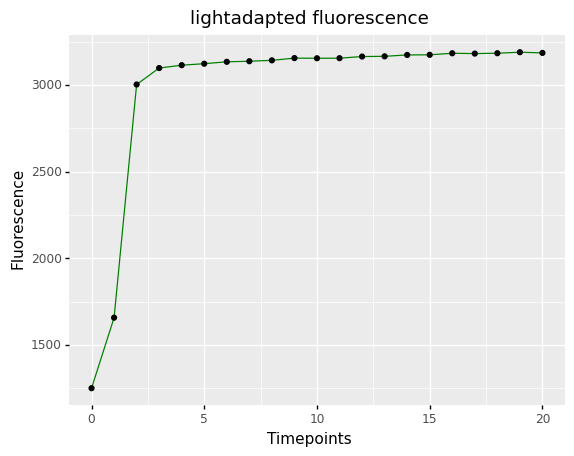

In [19]:
light_da, light_fig, light_df = pcv.photosynthesis.reassign_frame_labels(ps_da=ps.lightadapted, mask=mask)

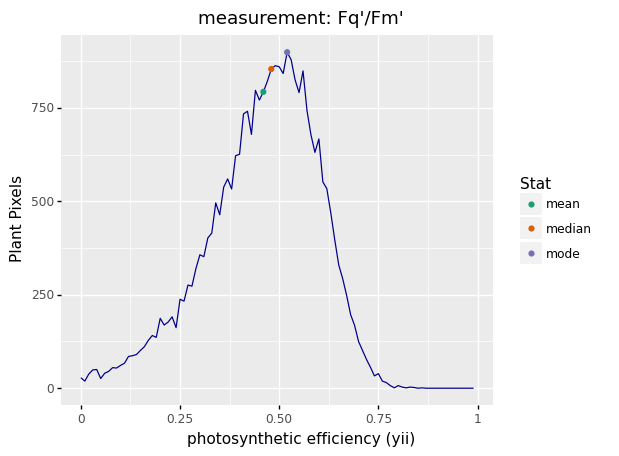

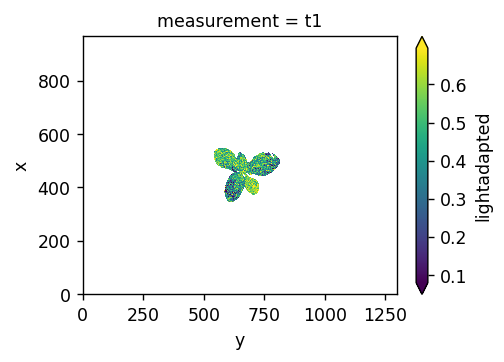

In [20]:
fqfm, fqfm_hist = pcv.photosynthesis.analyze_yii(ps_da=light_da, mask=mask, measurement_labels=["Fq'/Fm'"])

Extract the CI red edge index from the data cube using the `spectral index` sub-package. The input for this function is most commonly a hyperspectral datacube, but this index can also be calculated from the frames availble in a photosynthesis image dataset. The PSII data that gets input here is the subset of frames that are labeled "spectral" and get called with the code `ps.spectral` since our whole PSII data cube is stored in a variable called `ps`. These indices are an expansion of the analyses possible with a PhenoVation system alone. 

/Users/hschuhl/Documents/GitHub/plantcv/plantcv/plantcv/spectral_index/spectral_index.py:194: RuntimeWarning: divide by zero encountered in true_divide
/Users/hschuhl/Documents/GitHub/plantcv/plantcv/plantcv/spectral_index/spectral_index.py:194: RuntimeWarning: invalid value encountered in true_divide


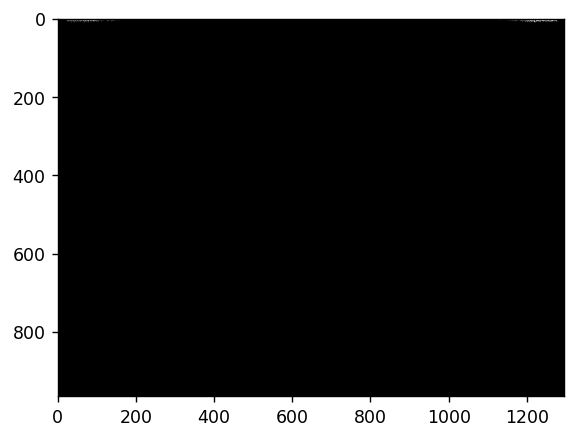

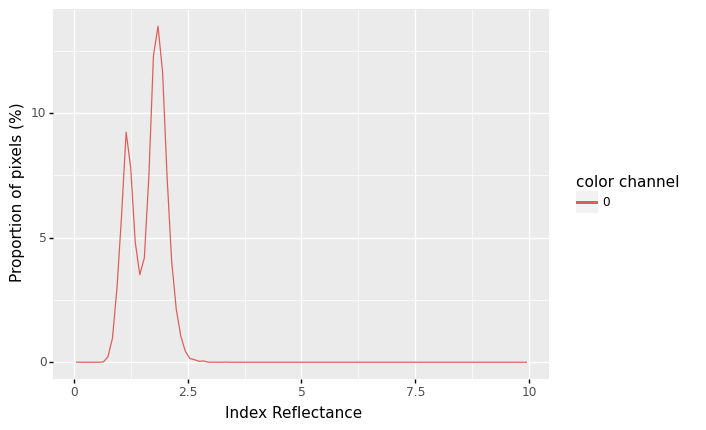

In [21]:
# Extract the CI red edge index 

# Inputs: 
#   hsi         = hyperspectral image (PlantCV Spectral_data instance)
ci = pcv.spectral_index.ci_rededge(hsi=ps.spectral)

# Inputs: 
#   index_array = hyperspectral image (PlantCV Spectral_data instance)
#   mask        = Binary mask made from selected contours
#   histplot    = if True plots histogram of intensity values
#   bins        = optional, number of classes to divide spectrum into
#   min_bin     = optional, minimum bin value ("auto" or user input minimum value)
#   max_bin     = optional, maximum bin value ("auto" or user input maximum value)
#   label       = optional label parameter, modifies the variable name of observations recorded
ci_hist = pcv.hyperspectral.analyze_index(index_array=ci, mask=mask, min_bin=0, max_bin=10)

/Users/hschuhl/Documents/GitHub/plantcv/plantcv/plantcv/spectral_index/spectral_index.py:163: RuntimeWarning: divide by zero encountered in true_divide
/Users/hschuhl/Documents/GitHub/plantcv/plantcv/plantcv/spectral_index/spectral_index.py:163: RuntimeWarning: invalid value encountered in subtract


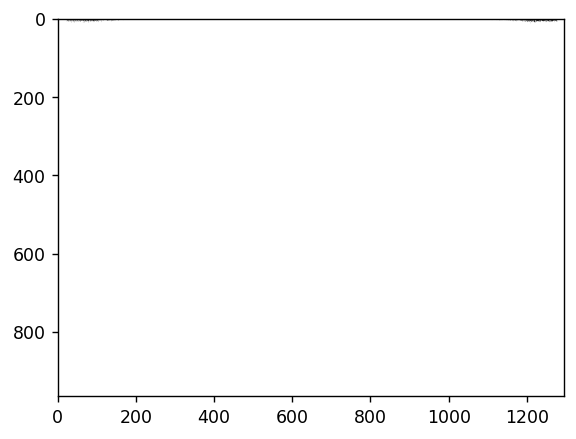

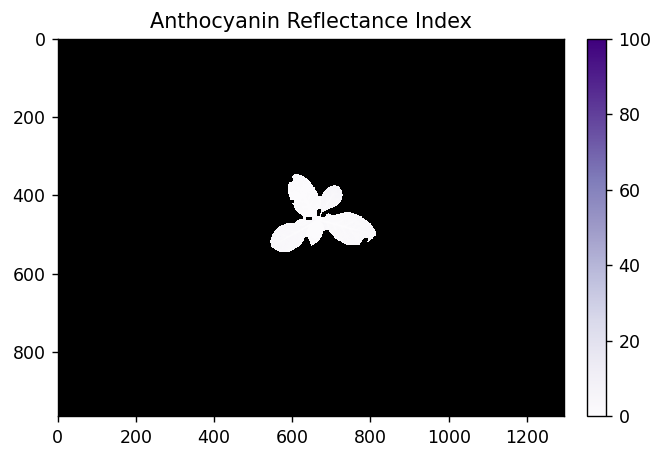

WARNING!!! The observed range of pixel values in your masked index provided is [-6.080843, 9.786804] but the user defined range of bins for pixel frequencies is [0, 100]. Adjust min_bin and max_bin in order to avoid cutting off data being collected.


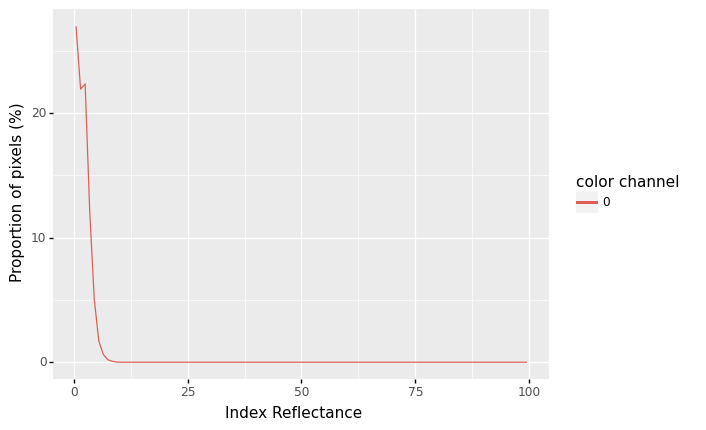

In [22]:
ari = pcv.spectral_index.ari(hsi=ps.spectral)

ari_ps = pcv.visualize.pseudocolor(gray_img=ari.array_data, min_value=0, max_value=100, 
                                    cmap="Purples", mask=mask, background="black", 
                                    title="Anthocyanin Reflectance Index")
ari_hist = pcv.hyperspectral.analyze_index(index_array=ari, mask=mask, min_bin=0, max_bin=100)


/Users/hschuhl/Documents/GitHub/plantcv/plantcv/plantcv/spectral_index/spectral_index.py:40: RuntimeWarning: invalid value encountered in true_divide


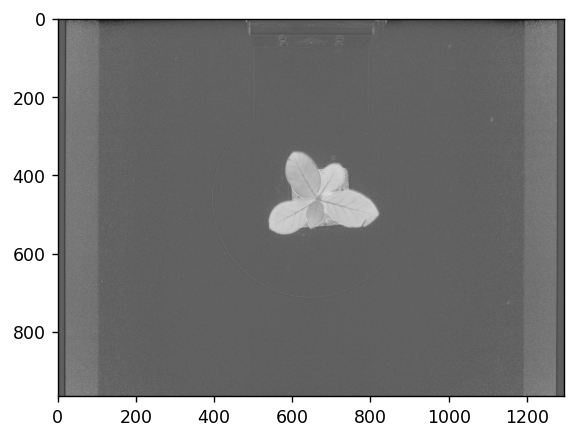

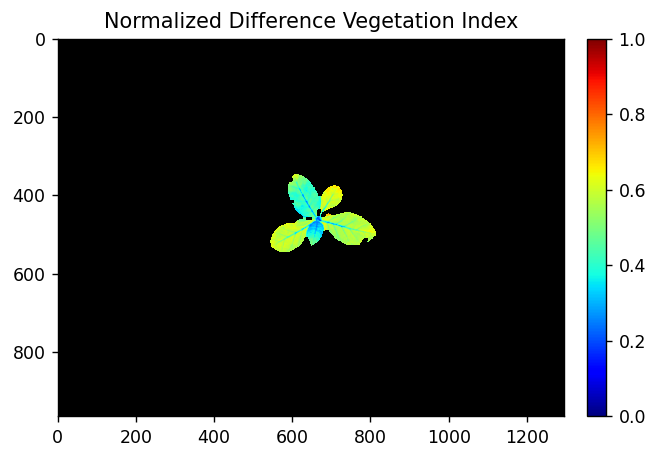

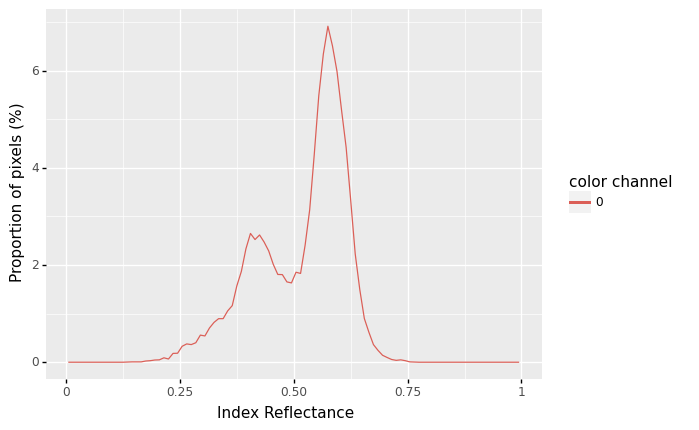

In [23]:
ndvi = pcv.spectral_index.ndvi(hsi=ps.spectral)

ndvi_ps = pcv.visualize.pseudocolor(gray_img=ndvi.array_data, min_value=0, max_value=1, 
                                        cmap="jet", mask=mask, background="black", 
                                        title="Normalized Difference Vegetation Index")

ndvi_hist = pcv.hyperspectral.analyze_index(index_array=ndvi, mask=mask, min_bin=0, max_bin=1)
